In [1]:
import os
import cv2
import random
import importlib
import numpy as np
import matplotlib.pyplot as plt
import torch
from time import time
from torchvision import transforms
from torchvision.utils import make_grid
%matplotlib inline

In [2]:
# Image path:
path_train = '/home/m20163692/data/imagenet/sres_data/train/'
path_test = '/home/m20163692/data/imagenet/sres_data/test/'
# Model weights:
PATH_G = 'model_g'
PATH_D = 'model_d'

l1_factor = 0.9
img_size = 128
batch_size = 64
upscale_factor = 4
threads = 8
n_gpu = 2
input_size = img_size // upscale_factor
print(f'input img = {input_size}x{input_size}, hres img = {img_size}x{img_size}')

input img = 32x32, hres img = 128x128


In [3]:
%%time
import custom_loader; importlib.reload(custom_loader)
from custom_loader import CustomLoader

input_transfrom = transforms.Compose([
                      transforms.Scale(input_size),
                      transforms.ToTensor(),
                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
target_transfrom = transforms.Compose([
                       transforms.Scale(img_size),
                       transforms.ToTensor(),
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
data_train = CustomLoader(path_train,
                          transform=input_transfrom,
                          target_transform=target_transfrom, crop_size=img_size)
data_test = CustomLoader(path_test,
                         transform=input_transfrom,
                         target_transform=target_transfrom, crop_size=img_size)
dloader_train = torch.utils.data.DataLoader(data_train, batch_size, True, num_workers=threads)
dloader_test = torch.utils.data.DataLoader(data_test, batch_size, num_workers=threads)

CPU times: user 387 ms, sys: 37.3 ms, total: 424 ms
Wall time: 428 ms


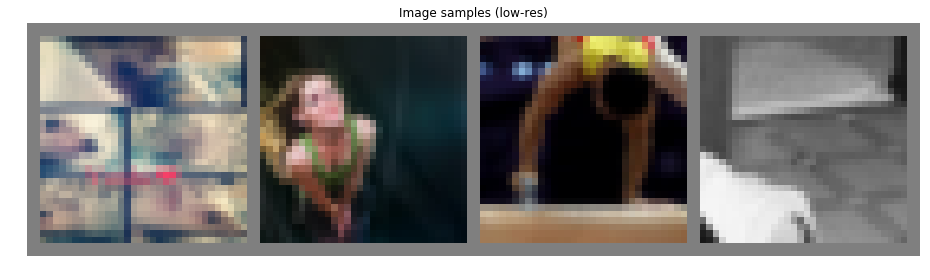

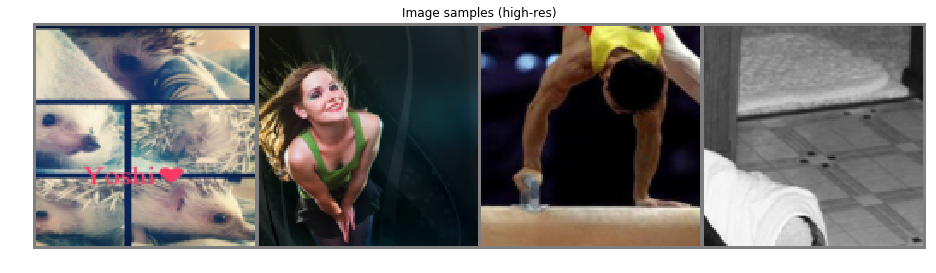

In [4]:
to_np = lambda x: np.transpose((x/2+0.5).clamp(0,1).numpy(), (1,2,0))

def show(img, fs=(4,4), title=None):
    plt.figure(figsize = fs)
    plt.imshow(to_np(img), interpolation='nearest')
    plt.axis('off')
    if title: plt.title(title)
    plt.show()

temp = iter(dloader_train).next()
n_imgs = 4
show(make_grid(temp[0][:n_imgs], nrow=n_imgs), (16,16), 'Image samples (low-res)')
show(make_grid(temp[1][:n_imgs], nrow=n_imgs), (16,16), 'Image samples (high-res)')
del(temp)

# Create model

In [5]:
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
import model_big; importlib.reload(model_big)
from model_big import SRES_GAN_D, SRES_GAN_G
from torch import FloatTensor as FT

# Util functions
def Var(*params):
    return Variable(FT(*params).cuda())

def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)): 
        m.weight.data.normal_(0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# Generator
netG = SRES_GAN_G().cuda()
netG = nn.DataParallel(netG, device_ids=[0, 1])
netG.apply(weights_init)
# Discriminator
netD = SRES_GAN_D().cuda()
netD = nn.DataParallel(netD, device_ids=[0, 1])
netD.apply(weights_init)
# Input placeholder
input = Var(batch_size, 3, img_size, img_size)
# The numbers 0 and -1
one = torch.FloatTensor([1]).cuda()
mone = one * -1
# Optimizers
optimizerD = optim.RMSprop(netD.parameters(), lr = 1e-4)
optimizerG = optim.RMSprop(netG.parameters(), lr = 1e-4)
# Test mse loss
test_loss = nn.MSELoss().cuda()

In [6]:
# Training functions
def downscale(images):
    avg_pool = nn.AvgPool2d(upscale_factor, upscale_factor)
    downscaled = avg_pool(images)
    return downscaled

def step_D(v, init_grad=None):
    err = netD(v).mean(0).view(1)
    if init_grad is not None:
        err.backward(init_grad)
    return err

def get_l1_loss(low_res, high_res):
    high_res_d = downscale(high_res)
    err = torch.mean(torch.abs(low_res - high_res_d))
    return err

def get_l1_loss2(img1, img2):
    err = torch.mean(torch.abs(img1 - img2))
    return err
    
def make_trainable(net, val): 
    for p in net.parameters(): p.requires_grad = val

In [7]:
# data_iter = iter(dloader_train)
# data_batch = next(data_iter)
# real = Variable(data_batch[1][:1].cuda())
# low_res = Variable(data_batch[0][:1].cuda())

# fake = netG(low_res)

# # disc_test = netD(fake)

In [8]:
# show(make_grid(real.data.cpu(), nrow=1))
# show(make_grid(fake.data.cpu(), nrow=1))

In [9]:
from math import log10

def train(epochs, first=True):
    gen_iterations = 0
    n = len(dloader_train)
    save_flag = 1
    print(f'Training on {len(dloader_train.dataset)} images for {epochs} epochs\n' +
          f'batch size : {batch_size} - batches per epoch : {n}')
    # n = 50 # test
    errDL = 0; errGL = 0; errL1 = 0; err_GL1 = 0; errDR = 0; errDF = 0
    for epoch in range(epochs):
        netG.train()
        t0 = time()
        data_iter = iter(dloader_train)
        i = 0
        while i < n:
            make_trainable(netD, True)
            d_iters = 20 if first and (gen_iterations < 25) else 5
            if gen_iterations % 500 == 0: 
                d_iters = 100

            j = 0
            while j < d_iters and i < n:
                j += 1; i += 1
                print(f'{i:04}/{n:04} gen it=%d - Loss_D: %.4f (R:%.4f|F:%.4f) Loss_GL1: %.4f Loss_G: %.4f Loss_L1: %.4f' %
                      (gen_iterations, errDL, errDR, errDF, err_GL1, errGL, errL1), end='\r')
                
                # Gradient clipping
                for p in netD.parameters():
                    p.data.clamp_(-0.01, 0.01)
                    
                data_batch = next(data_iter)
                netD.zero_grad()
                
                # Real loss
                real = Variable(data_batch[1].cuda())
                errD_real = step_D(real, one)
                errDR = errD_real.data[0]
                
                # Fake loss
                low_res = Variable(data_batch[0].cuda())
                fake = netG(low_res)
                input.data.resize_(real.size()).copy_(fake.data)
                errD_fake = step_D(input, mone)
                errDF = errD_fake.data[0]
                errD = errD_fake - errD_real
                optimizerD.step()
                errDL = errD.data[0]
                

            make_trainable(netD, False)
            netG.zero_grad()
            # data_batch = next(data_iter)
            real = Variable(data_batch[1].cuda())
            lr = Variable(data_batch[0].cuda())
            hr = netG(lr)
            # Generator loss:
            errG = -step_D(hr) * (1 - l1_factor)
            errG.backward(one, retain_variables=True)
            errGL = errG.data[0]
            # L1 loss:
            # err_L1 = get_l1_loss(lr, hr) * l1_factor # with downscale
            err_L1 = get_l1_loss2(hr, real) * l1_factor # without downscale
            err_L1.backward()
            errL1 = err_L1.data[0]
            # Final generator loss
            err_GL1 = errGL + errL1
            optimizerG.step()
            gen_iterations += 1
            
            if save_flag == -1:
                p_g = PATH_G + '_temp.pkl'
                p_d = PATH_D + '_temp.pkl'
            else:
                p_g = PATH_G + '.pkl'
                p_d = PATH_D + '.pkl'
            
            checkpoint(p_g, p_d)
            save_flag *= -1
            h['loss_g'].append(errGL)
            h['loss_d'].append(errDL)
            h['loss_l1'].append(errL1)
            h['loss_gl1'].append(err_GL1)
            
        psnr = test()
        h['psnr'].append(psnr)
        print('[%d/%d][%d/%d] Loss_D: %f Loss_GL1: %f Loss_G: %f Loss_L1: %f (%.2fs)' % (
            epoch+1, epochs, gen_iterations, n,
            errDL, err_GL1, errGL, errL1, time() - t0))
        
def test():
    netG.eval()
    avg_psnr = 0
    eval_loss = 0
    t = len(dloader_test)
    for batch in dloader_test:
        # inputs
        input = Variable(batch[0].cuda())
        target = Variable(batch[1].cuda())
        # loss
        loss = test_loss(netG(input), target)
        eval_loss += loss.data[0]
        psnr = 10 * log10(1 / loss.data[0])
        avg_psnr += psnr
        
    print('\tAvg. PSNR: %.4f dB - Validation loss: %.4f                                                '
          % (avg_psnr / t, eval_loss / t))
    return avg_psnr / t
        
def checkpoint(fpath_g, fpath_d):
    torch.save({'model': netG.state_dict(),
                'optimizer': optimizerG.state_dict()}, fpath_g)
    torch.save({'model': netD.state_dict(),
                'optimizer': optimizerD.state_dict()}, fpath_d)
    
def load_checkpoint(fpath_g=PATH_G + '.pkl', fpath_d=PATH_D + '.pkl'):
    g = torch.load(fpath_g)
    d = torch.load(fpath_d)
    netG.load_state_dict(g['model'])
    optimizerG.load_state_dict(g['optimizer'])
    netD.load_state_dict(d['model'])
    optimizerD.load_state_dict(d['optimizer'])
    
def update_lr(lr):
    for param_group in optimizerG.param_groups:
        param_group['lr'] = lr
    
    for param_group in optimizerD.param_groups:
        param_group['lr'] = lr

h = {}
h['loss_g'] = []
h['loss_d'] = []
h['loss_l1'] = []
h['loss_gl1'] = []
h['psnr'] = []

In [ ]:
%%time
train(1000)

Training on 59500 images for 1000 epochs
batch size : 64 - batches per epoch : 930
	Avg. PSNR: 13.9605 dB - Validation loss: 0.0402                                                L1: 0.1364
[1/1000][95/930] Loss_D: 0.000650 Loss_GL1: 0.146869 Loss_G: -0.000062 Loss_L1: 0.146931 (1721.05s)
	Avg. PSNR: 15.5318 dB - Validation loss: 0.0280                                                _L1: 0.1126
[2/1000][281/930] Loss_D: 0.000646 Loss_GL1: 0.116488 Loss_G: -0.000061 Loss_L1: 0.116549 (2153.73s)
	Avg. PSNR: 16.2730 dB - Validation loss: 0.0236                                                _L1: 0.09371
[3/1000][467/930] Loss_D: 0.000632 Loss_GL1: 0.101918 Loss_G: -0.000058 Loss_L1: 0.101975 (2152.92s)
	Avg. PSNR: 16.4268 dB - Validation loss: 0.0228                                                _L1: 0.09387
[4/1000][634/930] Loss_D: 0.000640 Loss_GL1: 0.098841 Loss_G: -0.000061 Loss_L1: 0.098902 (2063.33s)
	Avg. PSNR: 17.1090 dB - Validation loss: 0.0195                                 

Process Process-139:
KeyboardInterrupt
Process Process-137:
Process Process-138:
Process Process-141:
Process Process-142:
Process Process-144:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-143:
  File "/home/m20163692/anaconda3/envs/ml/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Process Process-140:
  File "/home/m20163692/anaconda3/envs/ml/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/m20163692/anaconda3/envs/ml/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 35, in _worker_loop
    r = index_queue.get()
  File "/home/m20163692/anaconda3/envs/ml/lib/python3.6/multiprocessing/queues.py", line 342, in get
    with self._rlock:
Traceback (most recent call last):
  File "/home/m20163692/anaconda3/envs/ml/lib/python3.6/

KeyboardInterrupt: 

In [ ]:
%%time
update_lr(1e-5)
train(10)

Training on 59500 images for 10 epochs
batch size : 64 - batches per epoch : 930
	Avg. PSNR: 17.6990 dB - Validation loss: 0.0170                                                L1: 0.0770
[1/10][95/930] Loss_D: 0.000711 Loss_GL1: 0.081303 Loss_G: -0.000063 Loss_L1: 0.081366 (1706.24s)
	Avg. PSNR: 17.7718 dB - Validation loss: 0.0168                                                _L1: 0.0721
[2/10][281/930] Loss_D: 0.000669 Loss_GL1: 0.074741 Loss_G: -0.000062 Loss_L1: 0.074803 (2146.30s)
	Avg. PSNR: 17.8162 dB - Validation loss: 0.0166                                                _L1: 0.0784
[3/10][467/930] Loss_D: 0.000709 Loss_GL1: 0.071463 Loss_G: -0.000064 Loss_L1: 0.071526 (2146.63s)
	Avg. PSNR: 17.6970 dB - Validation loss: 0.0170                                                _L1: 0.0752
[4/10][634/930] Loss_D: 0.000698 Loss_GL1: 0.079095 Loss_G: -0.000061 Loss_L1: 0.079156 (2054.31s)


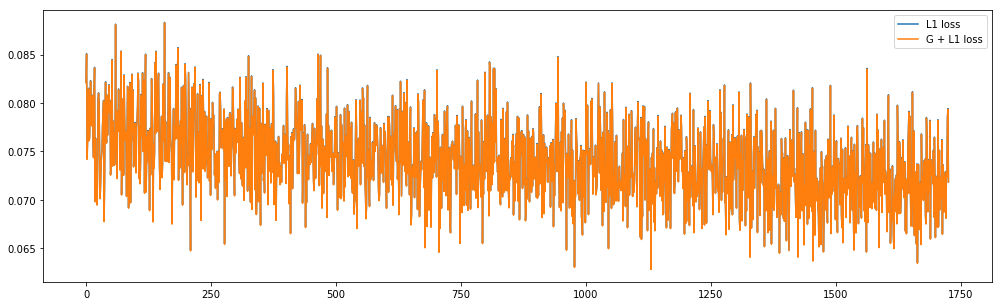

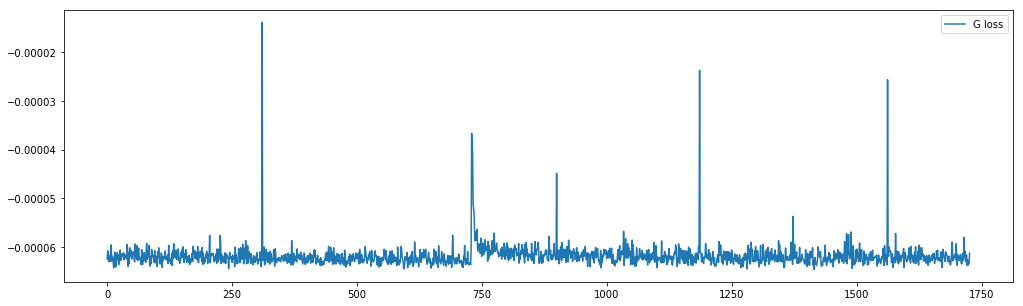

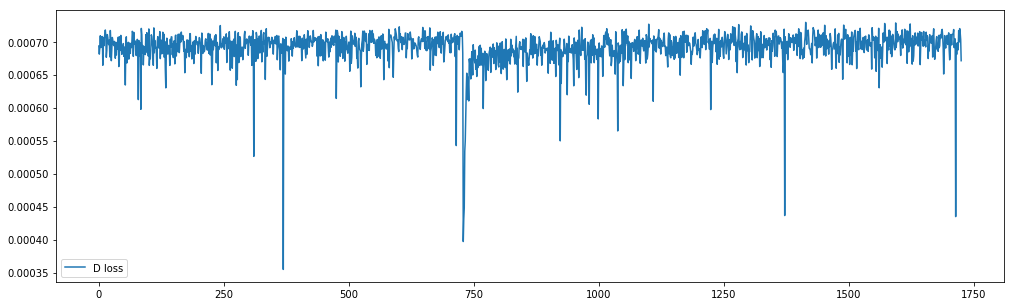

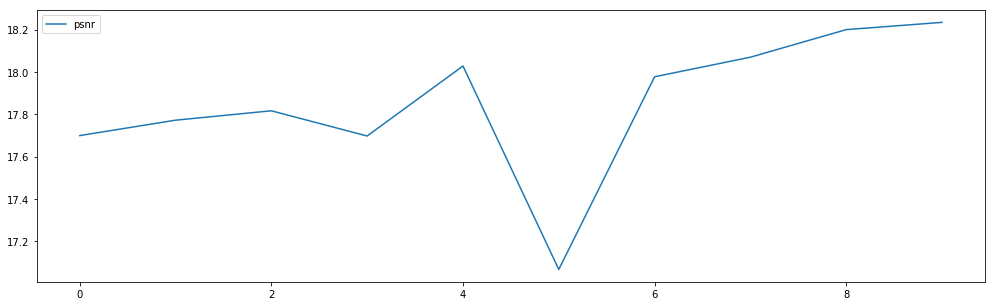

In [14]:
plt.figure(figsize=(17,5))
plt.plot(h['loss_l1'], label='L1 loss')
plt.plot(h['loss_gl1'], label='G + L1 loss')
plt.legend()
plt.show()

plt.figure(figsize=(17,5))
plt.plot(h['loss_g'], label='G loss')
plt.legend()
plt.show()

plt.figure(figsize=(17,5))
plt.plot(h['loss_d'], label='D loss')
plt.legend()
plt.show()

plt.figure(figsize=(17,5))
plt.plot(h['psnr'], label='psnr')
plt.legend()
plt.show()

In [17]:
checkpoint(PATH_G + '.pkl', PATH_D + '.pkl')
os.remove(PATH_G + '_temp.pkl')
os.remove(PATH_D + '_temp.pkl')

# View

In [10]:
# LOAD
load_checkpoint()

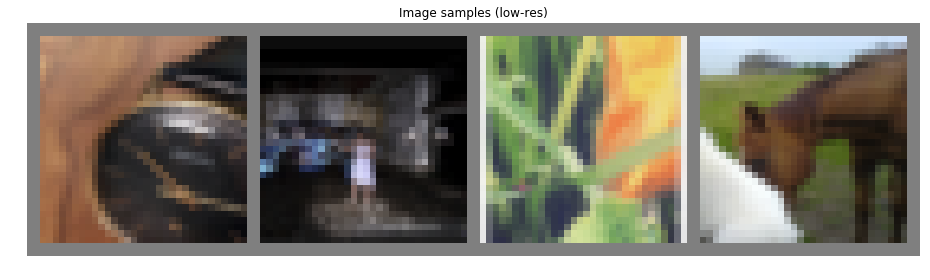

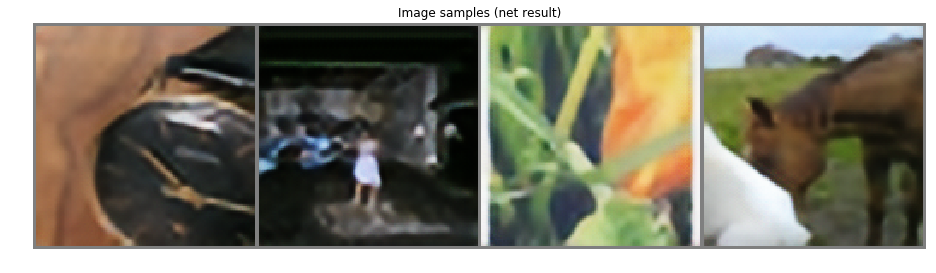

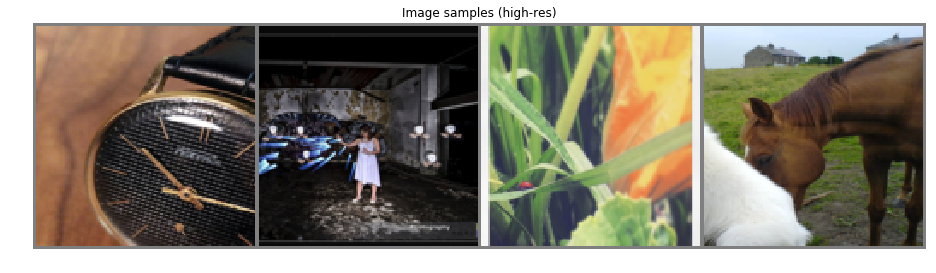

In [31]:
netG.eval()
n_imgs = 4
dloader_show = torch.utils.data.DataLoader(data_test, batch_size, True, num_workers=threads)
temp = iter(dloader_show).next()
temp_res = netG(Var(temp[0][:n_imgs])).data.cpu()
show(make_grid(temp[0][:n_imgs], nrow=n_imgs), (16,16), 'Image samples (low-res)')
show(make_grid(temp_res, nrow=n_imgs), (16,16), 'Image samples (net result)')
show(make_grid(temp[1][:n_imgs], nrow=n_imgs), (16,16), 'Image samples (high-res)')
del(temp); del(temp_res)

# Testing on different resolutions

From; 21x16
To  : 84x64


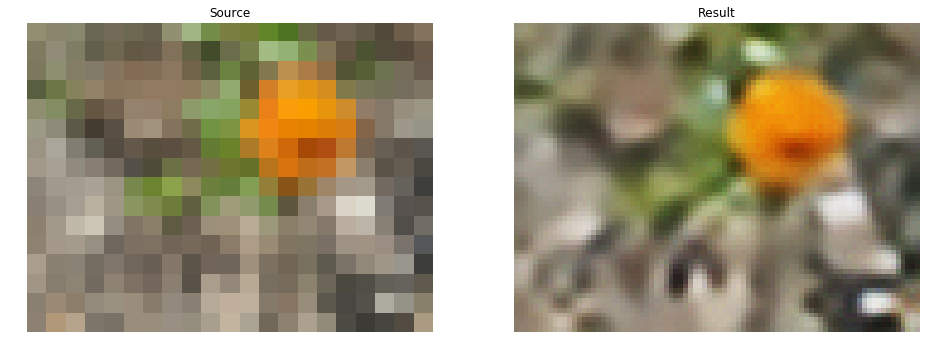

From; 64x48
To  : 256x192


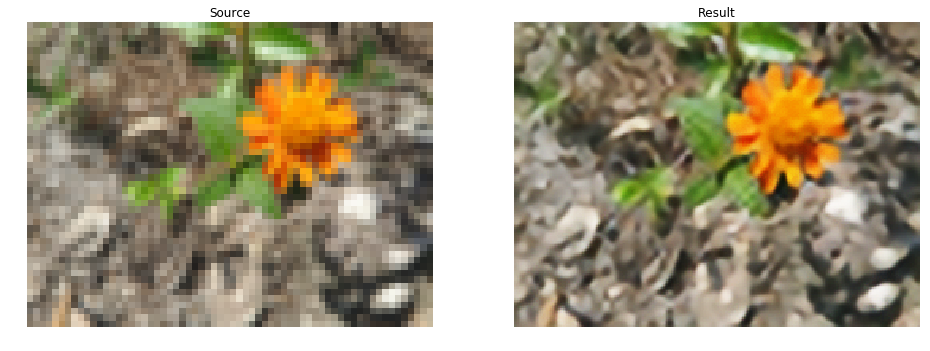

From; 128x96
To  : 512x384


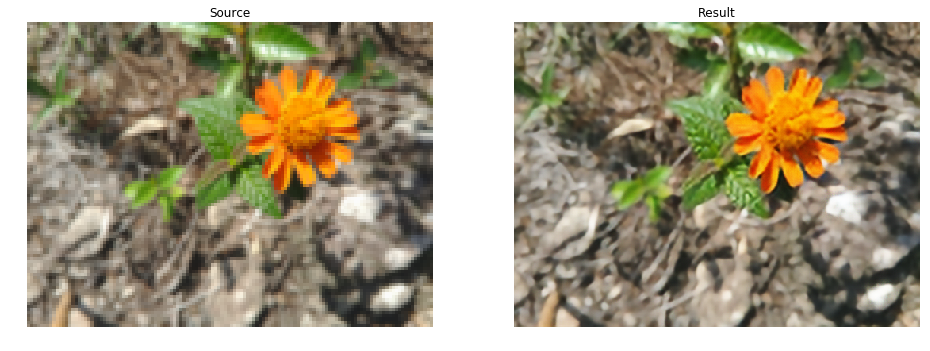

In [38]:
from PIL import Image

transfrom = lambda x: transforms.Compose([
                          transforms.Scale(x),
                          transforms.ToTensor(),
                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

def upscale_img(path, resize=100, iter=1):
    netG.eval()
    test_img = Image.open(path).convert('RGB')
    test_img = transfrom(resize)(test_img)
    test_img.unsqueeze_(0)
    test_res = Var(test_img)
    for _ in range(iter):
        test_res = netG(test_res)
    test_res = test_res.data.cpu()
    test_img = to_np(test_img[0])
    test_res = to_np(test_res[0])
    print(f'From; {test_img.shape[1]}x{test_img.shape[0]}')
    print(f'To  : {test_res.shape[1]}x{test_res.shape[0]}')
    
    plt.figure(figsize=(16,16))
    plt.subplot(1, 2, 1)
    plt.imshow(test_img)
    plt.title('Source')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(test_res)
    plt.title('Result')
    plt.axis('off')
    plt.show()

for i in [16, 48, 96]: upscale_img('../P70301-102125.jpg', i)